# Rating Predictor for Yelp Reviews

In [1]:
# Import libraries
import requests
import json
import time
import pandas as pd
from bs4 import BeautifulSoup

Get reviews

In [32]:
def parse_page(html):
    """
    Parse the reviews on a single page of a restaurant.
    
    Args:
        html (string): String of HTML corresponding to a Yelp restaurant

    Returns:
        tuple(list, string): a tuple of two elements
            first element: list of dictionaries corresponding to the extracted review information
            second element: URL for the next page of reviews (or None if it is the last page)
    """
    review_list = []
    soup = BeautifulSoup(html, 'html.parser')
    for review_block in soup.find_all('div', attrs={'class': 'review review--with-sidebar'}):
        review_id = user_id = rating = date = text = None
        if 'data-review-id' in review_block.attrs:
            review_id = review_block['data-review-id']
        if 'data-signup-object' in review_block.attrs and review_block['data-signup-object'].startswith('user_id:'):
            user_id = review_block['data-signup-object'][8:]
        rating_div = review_block.find('div', attrs={'class': 'i-stars'})
        if 'title' in rating_div.attrs:
            rating = float(rating_div['title'].split()[0])
        date_span = review_block.find('span', attrs={'class': 'rating-qualifier'})
        if date_span:
            date = date_span.getText().strip()
        review_content = review_block.find('div', attrs={'class': 'review-content'})
        if review_content:
            text = review_content.find('p').getText()
        if review_id and user_id and rating and date and text:
            review_list.append({
                'review_id': review_id,
                'user_id': user_id,
                'rating': rating,
                'date': date,
                'text': text
            })
    next_link = None
    next_ele = soup.find('a', attrs={'class': 'u-decoration-none next pagination-links_anchor'})
    if next_ele and 'href' in next_ele.attrs:
        next_link = next_ele['href']
    return review_list, next_link

In [53]:
def scrape_all_reviews(restaurants):
    for i, restaurant in enumerate(restaurants):
        print("restaurant: ", i)
        reviews = []
        url = restaurant['url']
        while url != None:
            response = requests.get(url)
            reviews_in_page, url = parse_page(response.content)
            reviews.extend(reviews_in_page)
        print(len(reviews))
        df = pd.DataFrame(reviews)
        df.to_csv('reviews.csv', mode='a', header=True)

In [ ]:
scrape_all_reviews(blist[42:])

restaurant:  0
990
restaurant:  1
618
restaurant:  2
440
restaurant:  3
801
restaurant:  4
552
restaurant:  5
1213
restaurant:  6
661
restaurant:  7
482
restaurant:  8
697
restaurant:  9
1183
restaurant:  10
1382
restaurant:  11
1044
restaurant:  12
1423
restaurant:  13
647
restaurant:  14
671
restaurant:  15
1150
restaurant:  16
574
restaurant:  17
150
restaurant:  18
1227
restaurant:  19
442
restaurant:  20
511
restaurant:  21
629
restaurant:  22
703
restaurant:  23
992
restaurant:  24
424
restaurant:  25
193
restaurant:  26
851
restaurant:  27
349
restaurant:  28
1177
restaurant:  29
449
restaurant:  30
1246
restaurant:  31
863
restaurant:  32
1189
restaurant:  33
420
restaurant:  34
623
restaurant:  35
1490
restaurant:  36
612
restaurant:  37
402
restaurant:  38
479
restaurant:  39
913
restaurant:  40
552
restaurant:  41
576
restaurant:  42
931
restaurant:  43
600
restaurant:  44
342
restaurant:  45
721
restaurant:  46
434
restaurant:  47
911
restaurant:  48
286
restaurant:  49
185

3


## Feature Extraction

In [31]:
# df = pd.read_csv(open('reviews.csv','rU'), header = None)
df = pd.read_csv(open('reviews.csv','rU'))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


In [34]:
# df['length'] = df.text.str.len()
# print(df)
def pre_process(df):
    new_df = df
    # Extract reviews and ratings
    new_df = new_df[['text', 'rating']]
    
    # remove invalid rows with ",text,rating"
    new_df = new_df[new_df.rating.astype(str).str.contains("rating") == False]

    # convert rating values to float
    new_df['rating'] = new_df['rating'].astype(float).fillna(0)
    # add length column to record word count of reviews
    new_df['length'] = new_df['text'].astype(str).apply(word_count)
    print(new_df.iloc[0].length)
    
    # remove punctations
    
    return new_df
    
def word_count(str):
    return len(str.split())

df = pre_process(df)
print(len(df))

df = df[df.rating >= 1.0]
print(len(df))


133
187864
187075


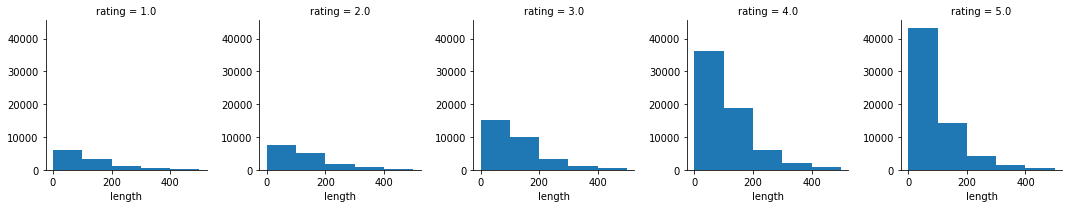

In [78]:
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np

g = sns.FacetGrid(data=df, col='rating')
g.map(plt.hist, 'length', bins=5, range = (0,500))
plt.show()

mean = 131.31633864947403
std = 119.2945705030534


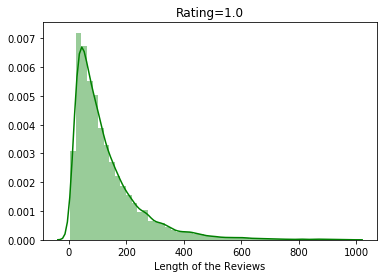

In [79]:
rating_1 = df[(df.rating == 1.0)]
plot = sns.distplot(rating_1['length'],label='rating=1.0',axlabel='Length of the Reviews',color="g")
plt.title('Rating=1.0')
fig = plot.get_figure()
fig.savefig("rating_1.png")
print ('mean =',np.mean(rating_1['length']))
print ('std =', np.std(rating_1['length']))
plt.show()

mean = 135.40501361017914
std = 113.91070388694456


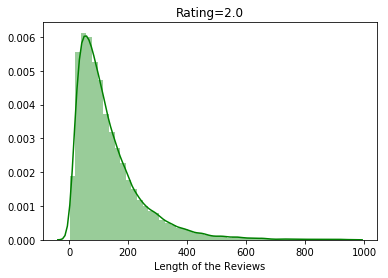

In [80]:
rating_2 = df[(df.rating == 2.0)]
plot = sns.distplot(rating_2['length'],label='rating=2.0',axlabel='Length of the Reviews',color="g")
plt.title('Rating=2.0')
fig = plot.get_figure()
fig.savefig("rating_2.png")
print ('mean =',np.mean(rating_2['length']))
print ('std =', np.std(rating_2['length']))
plt.show()

mean = 127.28331969225732
std = 103.14006644676003


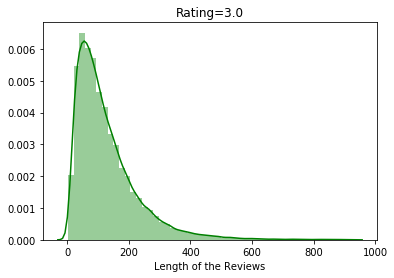

In [81]:
rating_3 = df[(df.rating == 3.0)]
plot = sns.distplot(rating_3['length'],label='rating=3.0',axlabel='Length of the Reviews',color="g")
plt.title('Rating=3.0')
fig = plot.get_figure()
fig.savefig("rating_3.png")
print ('mean =',np.mean(rating_3['length']))
print ('std =', np.std(rating_3['length']))
plt.show()

mean = 115.35467781908302
std = 99.38202100760289


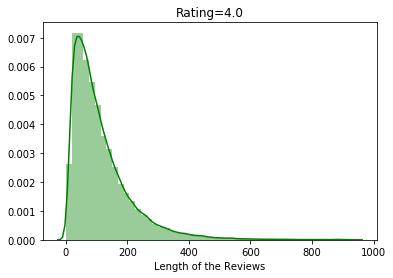

In [82]:
rating_4 = df[(df.rating == 4.0)]
plot = sns.distplot(rating_4['length'],label='rating=4.0',axlabel='Length of the Reviews',color="g")
plt.title('Rating=4.0')
fig = plot.get_figure()
fig.savefig("rating_4.png")
print ('mean =',np.mean(rating_4['length']))
print ('std =', np.std(rating_4['length']))
plt.show()

mean = 95.52085112992157
std = 92.95112461530366


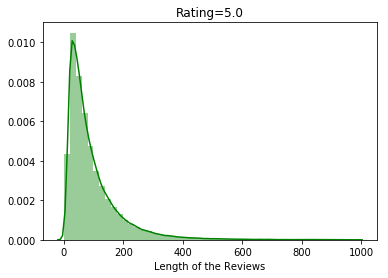

In [83]:
rating_5 = df[(df.rating == 5.0)]
plot = sns.distplot(rating_5['length'],label='rating=5.0',axlabel='Length of the Reviews',color="g")
plt.title('Rating=5.0')
fig = plot.get_figure()
fig.savefig("rating_5.png")
print ('mean =',np.mean(rating_5['length']))
print ('std =', np.std(rating_5['length']))
plt.show()

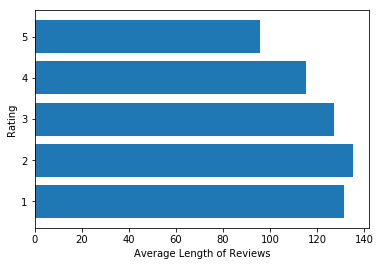

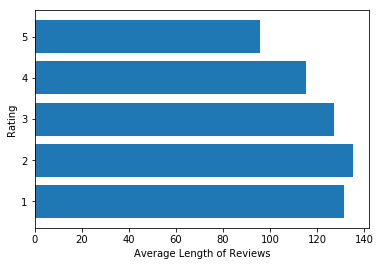

In [86]:
mean_length = [np.mean(rating_1['length']), np.mean(rating_2['length']), \
               np.mean(rating_3['length']), np.mean(rating_4['length']), np.mean(rating_5['length'])]
rating_classes = [1,2,3,4,5]

fig, ax = plt.subplots()

plt.barh(rating_classes, mean_length)
ax.set_xlabel('Average Length of Reviews')
ax.set_ylabel('Rating')

plt.savefig("average_length.png")
# for i, v in enumerate(d):
#     ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')

plt.show()

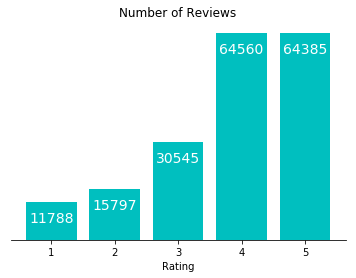

In [141]:
# print(df)
rating_classes = [1,2,3,4,5]
rating_size = [len(df[df.rating == 1.0]), len(df[df.rating == 2.0]), len(df[df.rating == 3.0]), \
              len(df[df.rating == 4.0]), len(df[df.rating == 5.0])]
# d = {'rating': rating_classes, 'size': rating_size}
# new_df = pd.DataFrame(data=d, index=None)
# print(new_df)

fig, ax = plt.subplots()

plt.bar(rating_classes, rating_size, color = 'c')
ax.set_xlabel('Rating')
plt.title('Number of Reviews')

for i, (rating_a, size_a) in enumerate(zip(rating_classes, rating_size)):
#     plt.text(s=rating_a, x=1, y=i, color="w", verticalalignment="center", size=28)
    plt.text(s=str(size_a), x=i+0.65, y=size_a-5000, color="w",
             verticalalignment="center", horizontalalignment="left", size=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.savefig("reviews_size.png")
plt.show()



In [7]:
five = df[(df.rating >= 1.0)]
# print(binary)
X = five.text
y = five.rating

import string

# remove stopwords, punctuations, to lower case
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)



In [61]:
# binary = df[(df.rating == 1.0) | (df.rating == 5.0)]
# # print(binary)
# X = binary.text
# y = binary.rating

# import string
# def text_process(text):
#     nopunc = [char for char in text if char not in string.punctuation]
#     nopunc = ''.join(nopunc)
    
#     return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# from sklearn.feature_extraction.text import CountVectorizer
# bow_transformer = CountVectorizer(analyzer=text_process).fit(X)


AttributeError: 'Series' object has no attribute 'text'

In [8]:
review_25 = X.iloc[24]
print(review_25)
bow_25 = bow_transformer.transform([review_25])
print(bow_25)

Delicious!  A bit pricey but worth the occasional indulgence.  This takes seafood to the highest level. Friends who don't even like seafood like it from here.  The little cotton candy surprise at the end of the meal was a huge hit.
  (0, 17174)	1
  (0, 21519)	1
  (0, 63634)	1
  (0, 69198)	1
  (0, 77604)	1
  (0, 86677)	1
  (0, 90486)	1
  (0, 91953)	1
  (0, 110367)	1
  (0, 110709)	1
  (0, 112122)	1
  (0, 114038)	1
  (0, 120825)	1
  (0, 121192)	2
  (0, 121905)	1
  (0, 125722)	1
  (0, 135415)	1
  (0, 149282)	1
  (0, 161152)	2
  (0, 174263)	1
  (0, 175779)	1
  (0, 194055)	1


In [9]:
X_ = bow_transformer.transform(X)

In [15]:
print(X_)

  (0, 132)	1
  (0, 4744)	1
  (0, 5910)	1
  (0, 6696)	1
  (0, 9132)	1
  (0, 14114)	1
  (0, 19919)	1
  (0, 20160)	1
  (0, 23353)	1
  (0, 24013)	2
  (0, 25158)	1
  (0, 29382)	1
  (0, 29614)	1
  (0, 40170)	1
  (0, 43989)	1
  (0, 44811)	1
  (0, 45184)	1
  (0, 48568)	1
  (0, 49456)	2
  (0, 49492)	1
  (0, 52019)	1
  (0, 54195)	2
  (0, 54447)	1
  (0, 55023)	1
  (0, 58656)	1
  :	:
  (102567, 167766)	1
  (102567, 168712)	1
  (102567, 170214)	1
  (102567, 171747)	1
  (102567, 180759)	1
  (102567, 183414)	1
  (102567, 187090)	1
  (102567, 190039)	1
  (102567, 193930)	1
  (102568, 37115)	1
  (102568, 54195)	1
  (102568, 78127)	1
  (102568, 79322)	1
  (102568, 81826)	1
  (102568, 84335)	1
  (102568, 98449)	1
  (102568, 104005)	1
  (102568, 111660)	1
  (102568, 115679)	1
  (102568, 130796)	1
  (102568, 132128)	1
  (102568, 132238)	1
  (102568, 146994)	1
  (102568, 152273)	1
  (102568, 158047)	1


## Train the Model

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=101)

NameError: name 'X_' is not defined

### Train by naive bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Predict

In [142]:
preds = nb.predict(X_test)

print(len(preds))

NameError: name 'nb' is not defined

Visualization of Prediction and True Value

### Evaluate

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds)) 

[[ 656  290  432  325  104]
 [ 192  217 1050  924  159]
 [  64   95 1316 3245  310]
 [  33   30  369 7434 2836]
 [  17   13   66 3398 7196]]


             precision    recall  f1-score   support

        1.0       0.68      0.36      0.47      1807
        2.0       0.34      0.09      0.14      2542
        3.0       0.41      0.26      0.32      5030
        4.0       0.49      0.69      0.57     10702
        5.0       0.68      0.67      0.68     10690

avg / total       0.54      0.55      0.52     30771



In [31]:
print(len(preds[preds == 2.0]))
y_test_ = np.array(y_test.tolist())
print(len(y_test_[y_test_ == 2.0]))

import numpy as np
print(np.average(np.absolute(preds - y_test)))

645
2542
0.559000357479
